In [5]:
# import all packages that will be used in the notebook
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from stack_data import markers_from_ranges


In [16]:
# Load ordinal collection and bitcoin price data
collections_df = pd.read_csv('./data/top_collection_price_history.csv', usecols=['collection', 'date', 'price'], parse_dates=['date'])
collections_df = collections_df.rename(columns={'price': 'collection_price'})
collections_df = collections_df.sort_values(by='date', ascending=True)
collections_df['date'] = pd.to_datetime(collections_df['date'])
collections_df['date'] = collections_df['date'].dt.tz_localize(None)

btc_df  = pd.read_csv('./data/btc_price_data.csv', usecols=['date', 'close'], parse_dates=['date'], dtype={'close': 'float64'}, date_format='%d-%b-%y')
btc_df = btc_df.rename(columns={'close': 'btc_price'})
btc_df = btc_df.sort_values(by='date', ascending=True)
btc_df['date'] = pd.to_datetime(btc_df['date'])
btc_df['date'] = btc_df['date'].dt.tz_localize(None)
btc_df['date'] = btc_df['date'].dt.date
btc_df.set_index('date', inplace=True)

# merge btc price into dataframe
df_dict = btc_df.to_dict(orient='dict')

# Fix the lambda to handle missing keys using get() for safe access
# Directly merge btc price into the dataframe for faster mapping
collections_df['btc_price'] = collections_df['date'].map(lambda x: df_dict['btc_price'][x.date()])


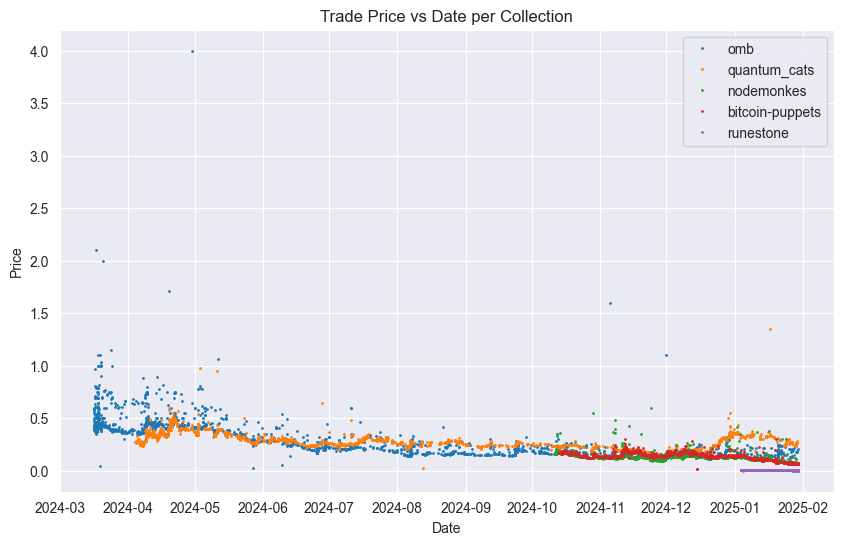

In [17]:
# Plot the traded prices for the collections
collections = collections_df['collection'].unique()
plt.figure(figsize=(10, 6))

for collection in collections:
    collection_data = collections_df[collections_df['collection'] == collection]
    plt.plot(collection_data['date'], collection_data['collection_price'], label=collection, marker='o', linestyle='', markersize=1)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Trade Price vs Date per Collection')
plt.legend()
plt.grid(True)
plt.show()

From the above we can see that there are some outliers - these could be due to rare asset purchased. For the purposes of this analysis we don't want these, so we're going to look at median prices over a suitable windows.

We are also going to merge the two datasets (collections and btc into one, for further processing later), and introduce some additional columns.

Let's try that out.

<Figure size 1200x800 with 0 Axes>

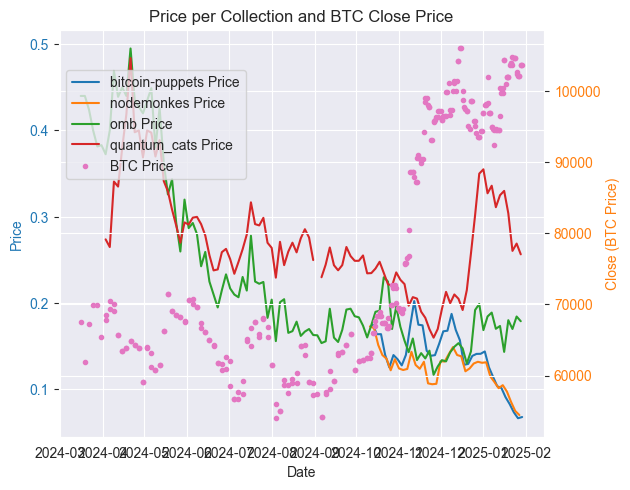

In [63]:
resample_period = '3D'

# Resample
resampled_df = (
    collections_df
    .set_index(['date', 'collection'])  # Temporarily set 'date' and 'collection' as the index
    .groupby('collection')  # Group by 'collection' to ensure it is preserved
    .resample(resample_period, level='date')  # Resample to x-day intervals on 'date'
    .median()  # Get the median values
    .reset_index()  # Reset the index to restore a standard DataFrame
)

# Apply transformations individually for each collection
resampled_df['btc_log_return'] = resampled_df.groupby('collection')['btc_price'].transform(lambda x: np.log(x / x.shift(1)))
resampled_df['collection_log_return'] = resampled_df.groupby('collection')['collection_price'].transform(lambda x: np.log(x / x.shift(1)))
resampled_df['collection_usd_price'] = resampled_df['collection_price'] * resampled_df['btc_price']

# Plot the collection price and btc price columns
plt.figure(figsize=(12, 8))
fig, ax1 = plt.subplots()

# Plot 'price' using ax1
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='tab:blue')

for collection in collections:
    data = resampled_df[resampled_df['collection'] == collection]
    ax1.plot(data['date'], data['collection_price'], label=f'{collection} Price', linestyle='-', marker=None)

ax1.tick_params(axis='y', labelcolor='tab:blue')

# Add the second axis for 'close'
ax2 = ax1.twinx()
ax2.set_ylabel('Close (BTC Price)', color='tab:orange')
ax2.plot(resampled_df['date'], resampled_df['btc_price'], label='BTC Price', color='tab:pink', linestyle='', marker='.')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add legends and grid
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.grid(True)
plt.title('Price per Collection and BTC Close Price')
plt.show()

We can also see that we don't have data for all the collections over the entire history, so we are going to filter to the last couple of months.

In [64]:
num_months_to_use = 3

latest_date = resampled_df['date'].max()
start_date = latest_date - pd.DateOffset(months=num_months_to_use)

first_date_per_collection = resampled_df.groupby('collection')['date'].min()
excluded_collections = first_date_per_collection[first_date_per_collection >= start_date].index.unique()
if len(excluded_collections) > 0:
    print(f"Warning: The following collections don't have complete data to the start date {start_date} and will be excluded: {list(excluded_collections)}")

df_for_analysis = resampled_df.copy()
df_for_analysis = df_for_analysis[(df_for_analysis['date'] >= start_date) & (~df_for_analysis['collection'].isin(excluded_collections))]

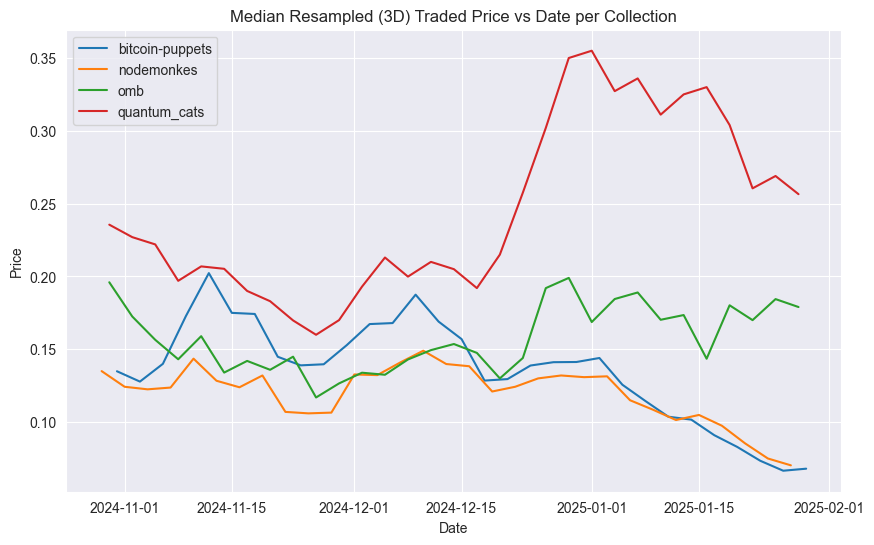

In [65]:
collections = df_for_analysis['collection'].unique()
plt.figure(figsize=(10, 6))

for collection in collections:
    collection_data = df_for_analysis[df_for_analysis['collection'] == collection]
    plt.plot(collection_data['date'], collection_data['collection_price'], label=collection)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Median Resampled ({}) Traded Price vs Date per Collection'.format(resample_period))
plt.legend()
plt.grid(True)
plt.show()

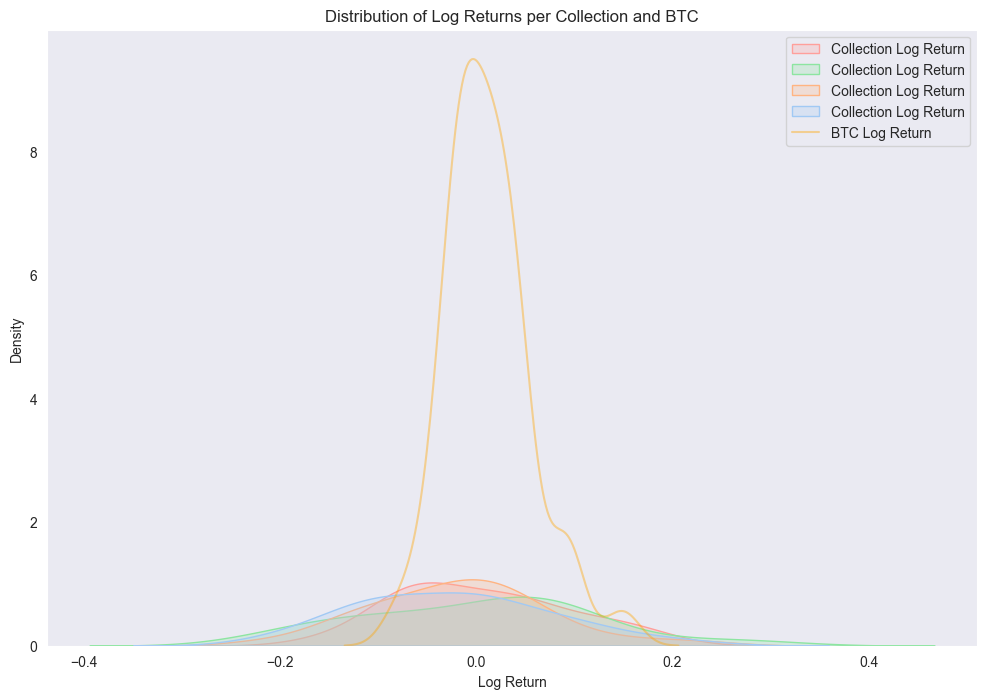

In [66]:
bins = 8

plt.figure(figsize=(12, 8))
sns.kdeplot(data=df_for_analysis.dropna(subset=['collection_log_return']), x='collection_log_return', hue='collection', palette='pastel', fill=True, label='Collection Log Return')
sns.kdeplot(data=df_for_analysis.dropna(subset=['btc_log_return']), x='btc_log_return', color='orange', fill=False, alpha=0.4, label='BTC Log Return')

plt.xlabel('Log Return')
plt.ylabel('Density')
plt.title('Distribution of Log Returns per Collection and BTC')
plt.legend()
plt.grid()
plt.show()

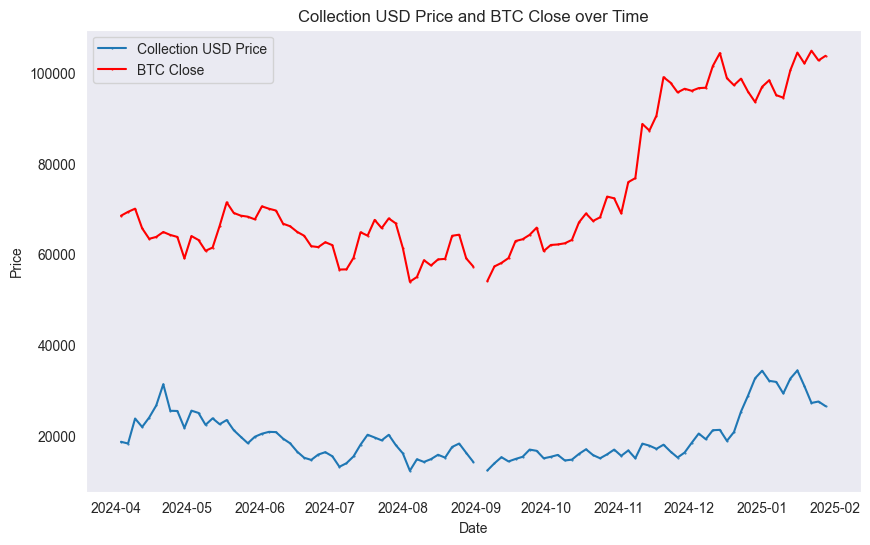

In [67]:
collection = 'quantum_cats'

plt.figure(figsize=(10, 6))
plt.plot(resampled_df[resampled_df['collection'] == collection]['date'], resampled_df[resampled_df['collection'] == collection]['collection_usd_price'], marker='.', linestyle='-', markersize=1, label='Collection USD Price')
plt.plot(resampled_df[resampled_df['collection'] == collection]['date'], resampled_df[resampled_df['collection'] == collection]['btc_price'], marker='.', linestyle='-', markersize=1, color='red', label='BTC Close')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Collection USD Price and BTC Close over Time')
plt.grid()
plt.legend()
plt.show()

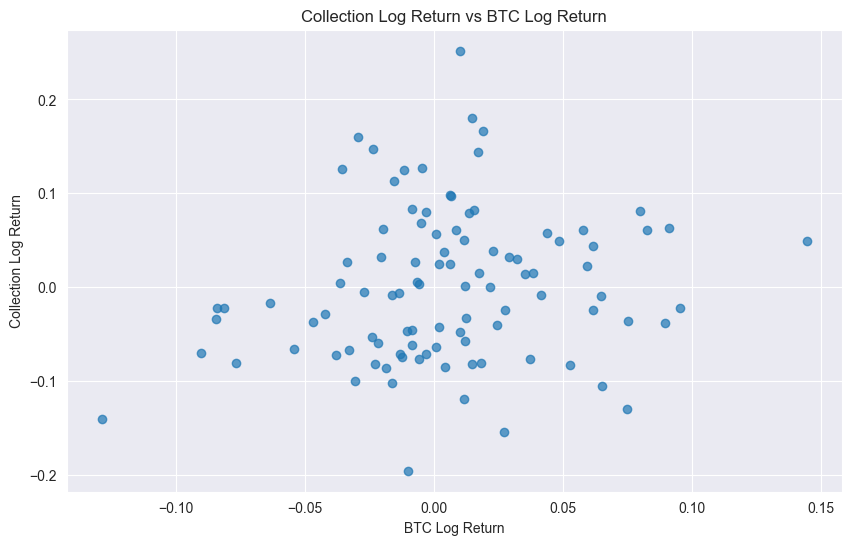

In [68]:
plt.figure(figsize=(10, 6))

plt.scatter(resampled_df[resampled_df['collection'] == collection]['btc_log_return'], resampled_df[resampled_df['collection'] == collection]['collection_log_return'], alpha=0.7)
plt.xlabel('BTC Log Return')
plt.ylabel('Collection Log Return')
plt.title('Collection Log Return vs BTC Log Return')
plt.grid(True)
plt.show()